In [37]:
# libraries for querying astro images and processing them
from astroquery.alma import Alma
from astroquery.skyview import SkyView
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
from astropy.modeling import models, fitting
from astropy.convolution import convolve, interpolate_replace_nans
from astropy.convolution import Gaussian2DKernel
from astropy.stats import sigma_clip, sigma_clipped_stats
from astropy.table import *
import os
import skimage
from skimage.filters import *
import numpy as np
from skimage import io, exposure, morphology, filters, feature
from skimage.feature import blob_dog, blob_log, blob_doh
import cv2
from math import sqrt
import scipy.optimize as opt
import statmorph
import photutils
import scipy.ndimage as ndi
import pandas as pd
from scipy import ndimage

# plotting libraries
from matplotlib import pylab
import pylab as py
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

# libraries for machine learning
from sklearn import decomposition
from sklearn import preprocessing
import scipy.stats as sstats

# libraries for deep learning
import torch
from torchvision import transforms
from torchvision import datasets

# random libraries
import time
import math
import warnings
import pickle
import random

import multiprocessing as mp

plt.style.use(astropy_mpl_style)
sns.reset_orig()

torch.manual_seed(69)
np.random.seed(69)
random.seed(69)

In [38]:
with open('full_data.pickle', 'rb') as f:
    full_data = pickle.load(f)
    

In [39]:
scaled_data = []
epsilon = 1

for img in list(full_data.values())[:]:
    img = np.log(img-img.min()+epsilon)
    scale_factor = 1/(img.max()-img.min())
    img_scaled = (img-img.min())*scale_factor
    scaled_data.append(img_scaled)

scaled_data = np.array(scaled_data)
     

In [40]:
print(np.array(list(full_data.values())[:]).shape)

(12540, 100, 100)


In [41]:
class GalacticDataset(torch.utils.data.Dataset):
    
    def __init__(self, X):
        if not torch.is_tensor(X):
            self.X = torch.from_numpy(X).reshape((X.shape[0], 1, X.shape[1], X.shape[2]))
            
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i]
    
    
BATCH_SIZE = 128

X = scaled_data
dataset = GalacticDataset(X=X)
loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,)

In [42]:
# Creating a PyTorch class
# 100*100 ==> 18 ==> 100*100
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
          
        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 10000 ==> 9
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(100 * 100, 1000),
            torch.nn.ReLU(),
            torch.nn.Linear(1000, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 3),
        )
      
        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 9 ==> 10000
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(3, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 1000),
            torch.nn.ReLU(),
            torch.nn.Linear(1000, 100 * 100)
        )
  
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self, x):
        return self.encoder(x)
    
# Model Initialization
model = AE()

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()
  


In [43]:
losses_epoch = []

In [90]:
# Using an Adam Optimizer with lr = 0.00001 for first 100 epochs, 0.000001 for next 200 epochs, total 300 epochs
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 0.00001,)

outputs = []
epochs = 90
for epoch in range(epochs):
    for (image) in loader:

        losses = []
      # Reshaping the image to (-1, 10000)
        image = image.reshape(-1, 100*100)

        # Output of Autoencoder
        reconstructed = model(image)

        # Calculating the loss function
        loss = loss_function(reconstructed, image)

        # The gradients are set to zero,
        # the the gradient is computed and stored.
        # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Storing the losses in a list  for plotting

        losses.append(loss.detach())
        if epoch == epochs-1:
            outputs.append([image, reconstructed])
    losses_epoch.append(losses)
    l = sum(losses)/len(losses)
#         outputs.append((epochs, image, reconstructed))
    print('epoch [{}/{}]'.format(epoch + 1, epochs,), f'Loss: {l}')
        


epoch [1/90] Loss: 0.004084228537976742
epoch [2/90] Loss: 0.003988561220467091
epoch [3/90] Loss: 0.0038651612121611834
epoch [4/90] Loss: 0.0036733446177095175
epoch [5/90] Loss: 0.003448567818850279
epoch [6/90] Loss: 0.003317325608804822
epoch [7/90] Loss: 0.0032490768935531378
epoch [8/90] Loss: 0.0032050174195319414
epoch [9/90] Loss: 0.0031685540452599525
epoch [10/90] Loss: 0.0031346729956567287
epoch [11/90] Loss: 0.0031014278065413237
epoch [12/90] Loss: 0.0030664594378322363
epoch [13/90] Loss: 0.0030270873103290796
epoch [14/90] Loss: 0.002979676239192486
epoch [15/90] Loss: 0.002920070430263877
epoch [16/90] Loss: 0.0028442300390452147
epoch [17/90] Loss: 0.002749330596998334
epoch [18/90] Loss: 0.0026287154760211706
epoch [19/90] Loss: 0.002482685726135969
epoch [20/90] Loss: 0.002289785770699382
epoch [21/90] Loss: 0.002059602178633213
epoch [22/90] Loss: 0.0019280242267996073
epoch [23/90] Loss: 0.001864721649326384
epoch [24/90] Loss: 0.001830440596677363
epoch [25/90]

tensor(0.0015)


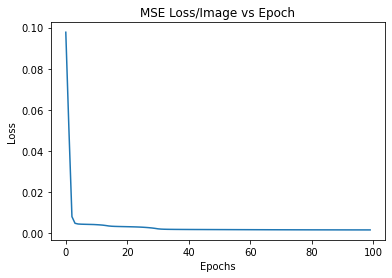

In [91]:
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MSE Loss/Image vs Epoch')

with torch.no_grad():
    # Plotting the last 100 values
    loss_x = []

    for epoch in losses_epoch:
        loss_x.append(sum(epoch)/len(epoch))
    
    plt.plot(loss_x[:])

print(min(loss_x))


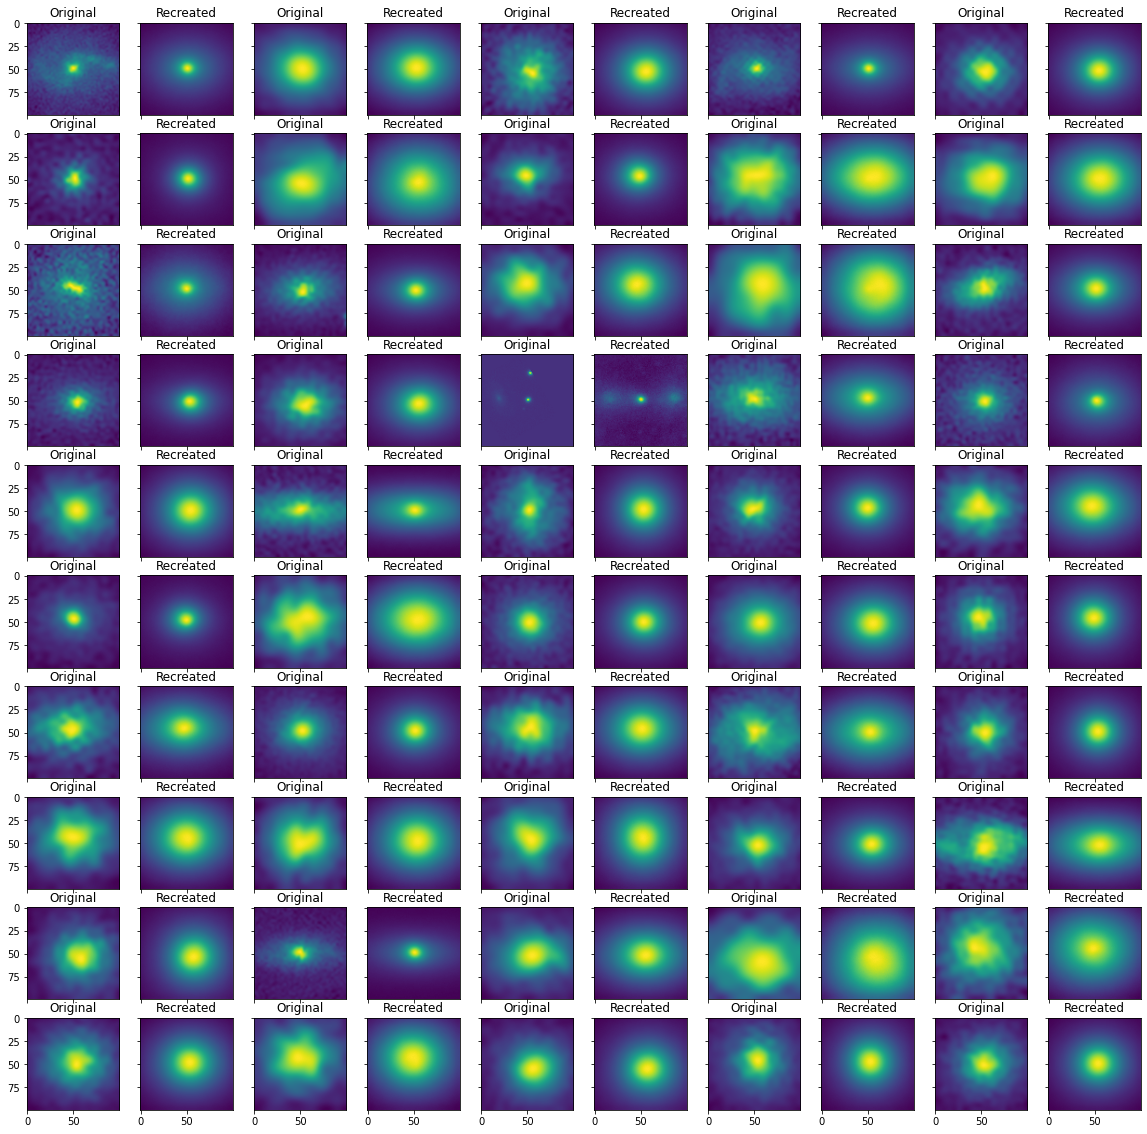

In [57]:
fig, axes = plt.subplots(10, 10, figsize=(20, 20), sharex=True, sharey=True)
ax = axes.ravel()
with torch.no_grad():
    i = 0
    for output in outputs:
        item = output[0]
        rec = output[1]

        # Reshape the array for plotting
        item = item.reshape(-1, 100, 100)
        ax[i].imshow(item[0])
        ax[i].set_title('Original')


        rec = rec.reshape(-1, 100, 100)
        ax[i+1].imshow(rec[0], )
        ax[i+1].set_title('Recreated')
        
        i += 2
        
        if i == 100:
            break

In [53]:
torch.save(model.state_dict(), 'ae_batch128_bottleneck3_logscaled_v3.pt')

with open('ae_b128bn3_logscaled_loss_v3.pickle', 'wb') as f:
    pickle.dump(losses_epoch, f)
    

# Reinitialise model, input model state_dict.


In [77]:
model = AE()
model.load_state_dict(torch.load('ae_batch128_bottleneck3_logscaled_v3.pt'))
with open('ae_b128bn3_logscaled_loss_v3.pickle', 'rb') as f:
    losses_epoch = pickle.load(f)

# Run first 9 images through CNNAE.

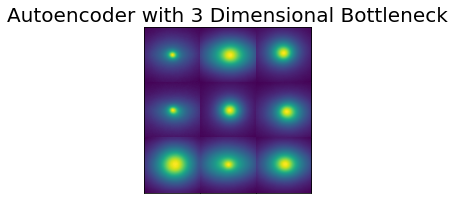

In [92]:
X=scaled_data
temp_ds = GalacticDataset(X=X[:9])
temp_loader = torch.utils.data.DataLoader(temp_ds, batch_size=1)

temp_outputs = []

for image in temp_loader:
    temp_outputs.append(model(image.reshape(-1, 100*100)))

with torch.no_grad():
    # original 9 galaxies

    fig = plt.figure(figsize=(3, 5), constrained_layout=False)
    outer_grid = fig.add_gridspec(1, 1, wspace=0, hspace=0)

    j = 0

    # gridspec inside gridspec
    inner_grid = outer_grid[0, 0].subgridspec(3, 3, wspace=0, hspace=-0.66)
    axs = inner_grid.subplots()  # Create all subplots for the inner grid.
    for (c, d), ax in np.ndenumerate(axs):
        ax.imshow(temp_outputs[j].reshape((100, 100)))
        ax.set(xticks=[], yticks=[])
        j += 1


    # show only the outside spines

    for i, ax in enumerate(fig.get_axes(), 1):
        ss = ax.get_subplotspec()
        if i == 2:
            ax.set_title('Autoencoder with 3 Dimensional Bottleneck', fontsize=20)
        ax.spines.top.set_visible(ss.is_first_row())
        ax.spines.bottom.set_visible(ss.is_last_row())
        ax.spines.left.set_visible(ss.is_first_col())
        ax.spines.right.set_visible(ss.is_last_col())

    plt.show()


# Check MSE Loss Histogram

In [93]:
temp_ds = GalacticDataset(X=X[:])
temp_loader = torch.utils.data.DataLoader(temp_ds, batch_size=1)

img_differences = []
i = 0
for (image) in temp_loader:
    
    # Reshaping the image to (-1, 10000)
    image = image.reshape(-1, 100*100)

    # Output of Autoencoder
    reconstructed = model(image)

    # Calculating the loss function
    loss = loss_function(reconstructed, image)
    img_differences.append(loss.detach().numpy().item())

    print(i, end='\r')
    i+=1
    
hist = np.histogram(img_differences, bins=100)
hist_dist = sstats.rv_histogram(hist)
x = np.linspace(0, max(img_differences), 50)
                
ppf = hist_dist.ppf(q=0.99)
print(ppf)



0.006544720635480203


Text(0.5, 0, 'MSE Loss')

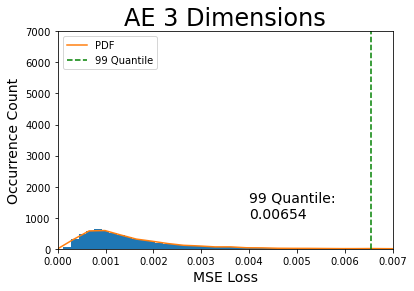

In [95]:
plt.hist(x = img_differences, bins=100, density=True)
plt.plot(x, hist_dist.pdf(x), label='PDF')

plt.axvline(x=ppf, ymin=0, ymax=7000, linestyle='--', color='green', label='99 Quantile')
plt.legend()
plt.xlim([0, 0.007])
plt.ylim([0, 7000])
plt.xticks([0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007])
plt.text(x=0.004, y=1000, s=f'99 Quantile:\n{round(ppf, 5)}', fontsize=14)
plt.title(f'AE 3 Dimensions', fontsize=24)
plt.ylabel('Occurrence Count', fontsize=14)
plt.xlabel('MSE Loss', fontsize=14)

# Encode the images

In [96]:
temp_ds = GalacticDataset(X=X[:])
temp_loader = torch.utils.data.DataLoader(temp_ds, batch_size=1)

encoded_images = []

for image in temp_loader:
    encoded_image = model.encode(image.reshape(-1, 100*100))
    with torch.no_grad():
        encoded_images.append(encoded_image.numpy().reshape(3))
                          

In [97]:
print(encoded_images[0])

[ 5.529083   7.9592185 -6.925221 ]


# Create galaxy type labelled data

In [103]:
with open('cls.pickle', 'rb') as f:
    cls = pickle.load(f)

In [104]:
sns_df = pd.DataFrame(data=encoded_images)
sns_df['type'] = cls


# Create r50 labelled data


In [105]:
with open('r50.pickle', 'rb') as f:
    r50_list = pickle.load(f)

In [106]:
sns_df['r50'] = r50_list

In [107]:
print(sns_df)

              0          1          2        type       r50
0      5.529083   7.959219  -6.925221      spiral  6.758434
1      7.796923  11.615603 -13.156291      spiral  2.840778
2      3.596743   8.600893  -8.609669   uncertain  2.089066
3      5.152812   6.487989  -7.234181   uncertain  3.888339
4      3.464783   5.650923  -8.596262  elliptical  3.081994
...         ...        ...        ...         ...       ...
12535  4.470015   5.732214  -7.916248   uncertain  3.231250
12536  2.735222   4.872576  -6.225640  elliptical  5.162690
12537  6.718647   9.039630 -11.460306   uncertain  3.745884
12538  4.955935   7.805467  -9.606533   uncertain  2.069203
12539  6.149783   8.746490  -8.993432      spiral  3.737998

[12540 rows x 5 columns]


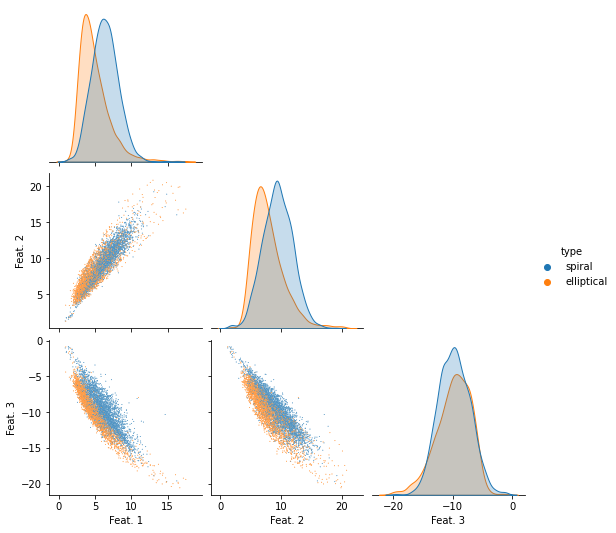

In [120]:
# seaborn pairplot


headers = []

for i, header in enumerate(sns_df.columns[:-2], 1):
    headers.append(f'Feat. {i}')

headers.append('type')
headers.append('r50')
sns_df.columns = headers

pp = sns.pairplot(data=sns_df[sns_df['type']!='uncertain'].iloc[:, :-1], hue='type', corner=True, plot_kws={"s": 1})
# pp = sns.pairplot(data=sns_df, hue='type', corner=True)


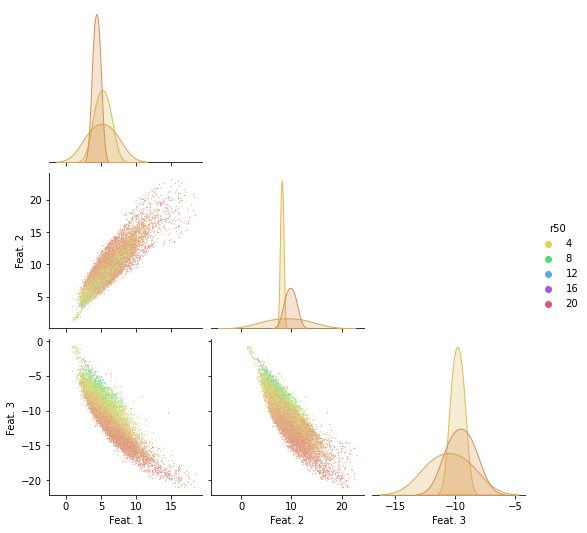

In [111]:
pp = sns.pairplot(data=sns_df, hue='r50', palette='hls',corner=True, plot_kws={"s": 1})

Text(0.5, 0.874, '3D Latent Space Representation of Galaxies')

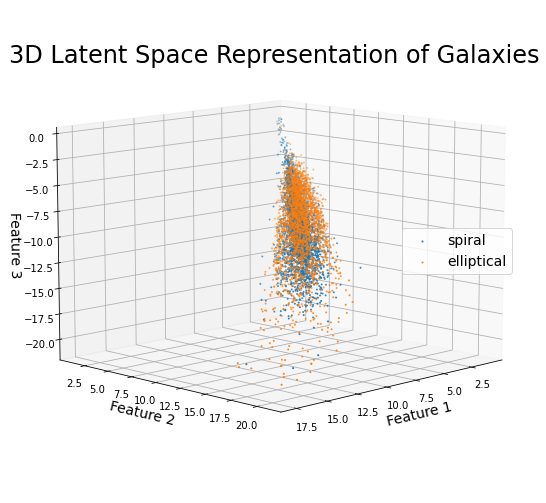

In [119]:
fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(projection='3d')
for c in sns_df['type'].unique(): 
    if c == 'uncertain':
        continue
    x = sns_df[sns_df['type'] == c]['Feat. 1']
    y = sns_df[sns_df['type'] == c]['Feat. 2']
    z = sns_df[sns_df['type'] == c]['Feat. 3']
    ax.scatter(x, y, z, s=1, label=c)

    
ax.set_xlabel('Feature 1', fontsize=14)
ax.set_ylabel('Feature 2', fontsize=14)
ax.set_zlabel('Feature 3', fontsize=14)
ax.view_init(elev=10, azim=45)

plt.legend(fontsize=14, loc='center right')
plt.title('3D Latent Space Representation of Galaxies', fontsize=24, y=0.95)

Text(0.5, 0.874, '3D Latent Space Representation of Galaxies')

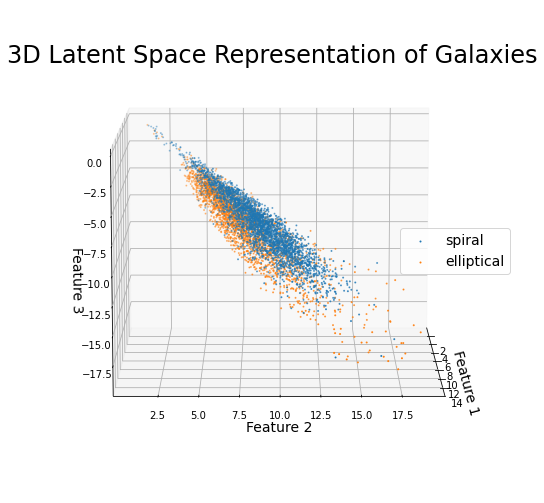

In [76]:
fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(projection='3d')
for c in sns_df['type'].unique(): 
    if c == 'uncertain':
        continue
    x = sns_df[sns_df['type'] == c]['Feat. 1']
    y = sns_df[sns_df['type'] == c]['Feat. 2']
    z = sns_df[sns_df['type'] == c]['Feat. 3']
    ax.scatter(x, y, z, s=1, label=c)

    
ax.set_xlabel('Feature 1', fontsize=14)
ax.set_ylabel('Feature 2', fontsize=14)
ax.set_zlabel('Feature 3', fontsize=14)
ax.view_init(elev=10, azim=0)

plt.legend(fontsize=14, loc='center right')
plt.title('3D Latent Space Representation of Galaxies', fontsize=24, y=0.95)

# Preparing dataset for pairwise plot with physical/morphological colormapping

In [31]:
# initialise dataframe with galaxy information

rcsed = Table.read('rcsedzoogz2gswlcx.fits', format='fits')
data = rcsed.to_pandas()
data['radec'] = data['ra_1'].astype(str) + ',' + data['dec_1'].astype(str)

i = 0

for j in range(3):
    data[f'Feat. {j+1}'] = None

for n, galaxy in enumerate(full_data.keys(), 0):

    try:
        index = data.loc[(data['radec'] == galaxy)].index

        for j in range(len(encoded_images[n])):
            data.at[index[0], f'Feat. {j+1}'] = encoded_images[n][j]

        print(i, end='\r')
        i += 1
    except:
        continue
        
final_dataset = data[data['Feat. 1'].isna() == False]
    

# 3D Latent Space vs R50

Text(0.55, 0.9016000000000001, '3D Latent Representation vs Log Petrosian R50')

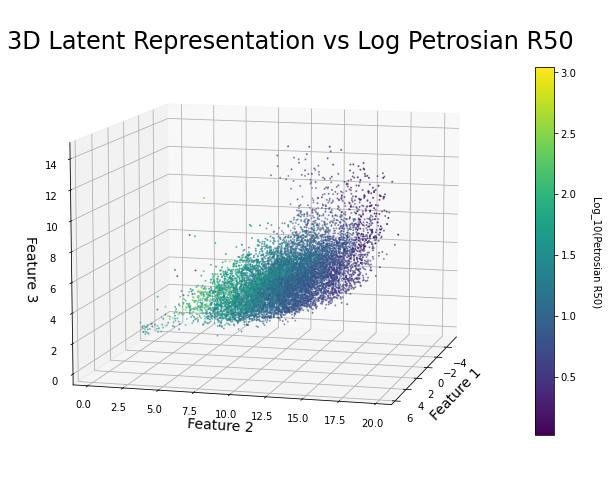

In [63]:
fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot(projection='3d')

x = final_dataset['Feat. 1']
y = final_dataset['Feat. 2']
z = final_dataset['Feat. 3']

c = final_dataset['petror50_r']
p = ax.scatter(x, y, z, s=1, c=np.log(c) )
    
ax.set_xlabel('Feature 1', fontsize=14)
ax.set_ylabel('Feature 2', fontsize=14)
ax.set_zlabel('Feature 3', fontsize=14)
ax.view_init(elev=10, azim=15)

cbar = fig.colorbar(p, fraction=0.03, pad=0.04)
cbar.set_label('Log_10(Petrosian R50)', rotation=270, labelpad=25)
plt.title('3D Latent Representation vs Log Petrosian R50', fontsize=24, x=0.55, y=0.98)

Text(0.55, 0.9016000000000001, '(Ellipticals Only)\n3D Latent Representation vs Log Petrosian R50')

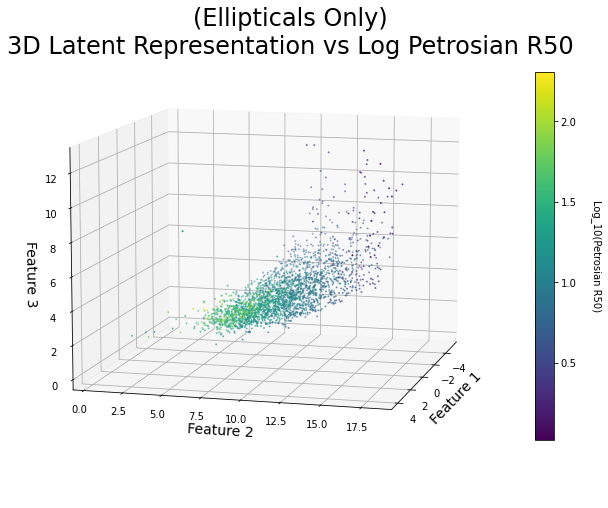

In [64]:
fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot(projection='3d')


x = final_dataset[final_dataset['elliptical']==1]['Feat. 1']
y = final_dataset[final_dataset['elliptical']==1]['Feat. 2']
z = final_dataset[final_dataset['elliptical']==1]['Feat. 3']

c = final_dataset[final_dataset['elliptical']==1]['petror50_r']
p = ax.scatter(x, y, z, s=1, c=np.log(c))

ax.set_xlabel('Feature 1', fontsize=14)
ax.set_ylabel('Feature 2', fontsize=14)
ax.set_zlabel('Feature 3', fontsize=14)
ax.view_init(elev=10, azim=15)

cbar = fig.colorbar(p, fraction=0.03,pad=0.04)
cbar.set_label('Log_10(Petrosian R50)', rotation=270, labelpad=25)
plt.title('(Ellipticals Only)\n3D Latent Representation vs Log Petrosian R50', fontsize=24, x=0.55, y=0.98)

Text(0.55, 0.9016000000000001, '(Spirals Only)\n3D Latent Representation vs Log Petrosian R50')

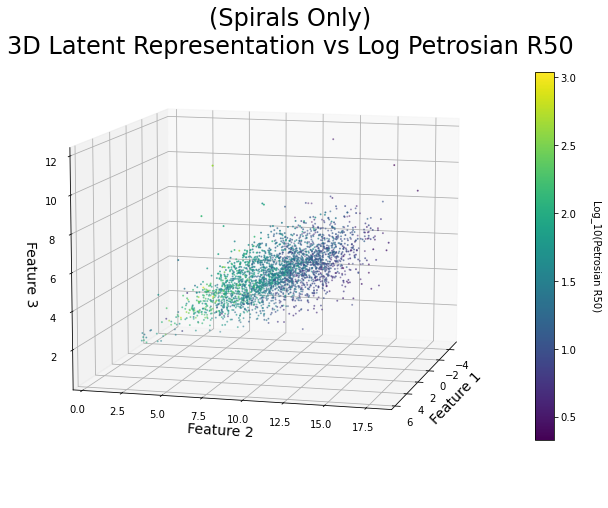

In [65]:
fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot(projection='3d')


x = final_dataset[final_dataset['spiral']==1]['Feat. 1']
y = final_dataset[final_dataset['spiral']==1]['Feat. 2']
z = final_dataset[final_dataset['spiral']==1]['Feat. 3']

c = final_dataset[final_dataset['spiral']==1]['petror50_r']
p = ax.scatter(x, y, z, s=1, c=np.log(c))

ax.set_xlabel('Feature 1', fontsize=14)
ax.set_ylabel('Feature 2', fontsize=14)
ax.set_zlabel('Feature 3', fontsize=14)
ax.view_init(elev=10, azim=15)

cbar = fig.colorbar(p, fraction=0.03,pad=0.04)
cbar.set_label('Log_10(Petrosian R50)', rotation=270, labelpad=25)
plt.title('(Spirals Only)\n3D Latent Representation vs Log Petrosian R50', fontsize=24, x=0.55, y=0.98)

# 3D Latent Space vs Age (SSP and exp SFH)

Text(0.55, 0.9016000000000001, '3D Latent Representation vs Age (SSP) Myr')

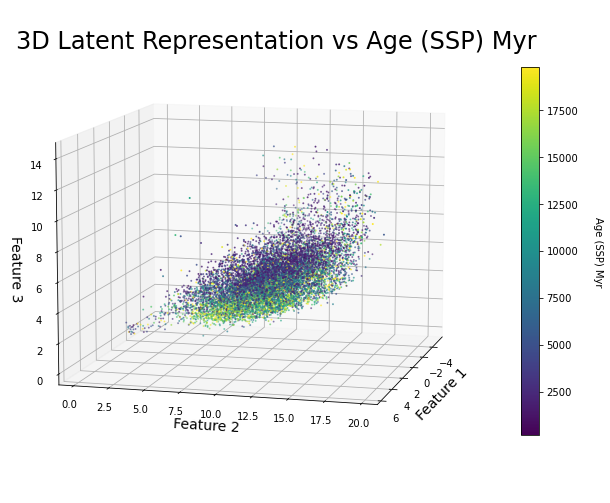

In [66]:
fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot(projection='3d')

x = final_dataset['Feat. 1']
y = final_dataset['Feat. 2']
z = final_dataset['Feat. 3']

c = final_dataset['ssp_age']
p = ax.scatter(x, y, z, s=1, c=(c) )
    
ax.set_xlabel('Feature 1', fontsize=14)
ax.set_ylabel('Feature 2', fontsize=14)
ax.set_zlabel('Feature 3', fontsize=14)
ax.view_init(elev=10, azim=15)

cbar = fig.colorbar(p, fraction=0.03, pad=0.04)
cbar.set_label('Age (SSP) Myr', rotation=270, labelpad=25)
plt.title('3D Latent Representation vs Age (SSP) Myr', fontsize=24, x=0.55, y=0.98)

Text(0.55, 0.9016000000000001, '3D Latent Representation vs Age (exp SFH) Myr')

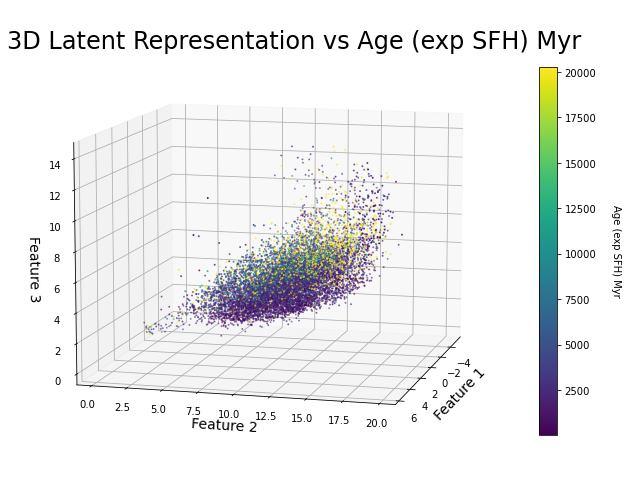

In [67]:
fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot(projection='3d')

x = final_dataset['Feat. 1']
y = final_dataset['Feat. 2']
z = final_dataset['Feat. 3']

c = final_dataset['exp_tau']
p = ax.scatter(x, y, z, s=1, c=(c) )
    
ax.set_xlabel('Feature 1', fontsize=14)
ax.set_ylabel('Feature 2', fontsize=14)
ax.set_zlabel('Feature 3', fontsize=14)
ax.view_init(elev=10, azim=15)

cbar = fig.colorbar(p, fraction=0.03, pad=0.04)
cbar.set_label('Age (exp SFH) Myr', rotation=270, labelpad=25)
plt.title('3D Latent Representation vs Age (exp SFH) Myr', fontsize=24, x=0.55, y=0.98)

# 3D Latent Representation vs Velocity Dispersion (SSP, exp SFH)

Text(0.55, 0.9016000000000001, '3D Latent Representation vs Log_10 Vel. Dispersion (SSP) km/s')

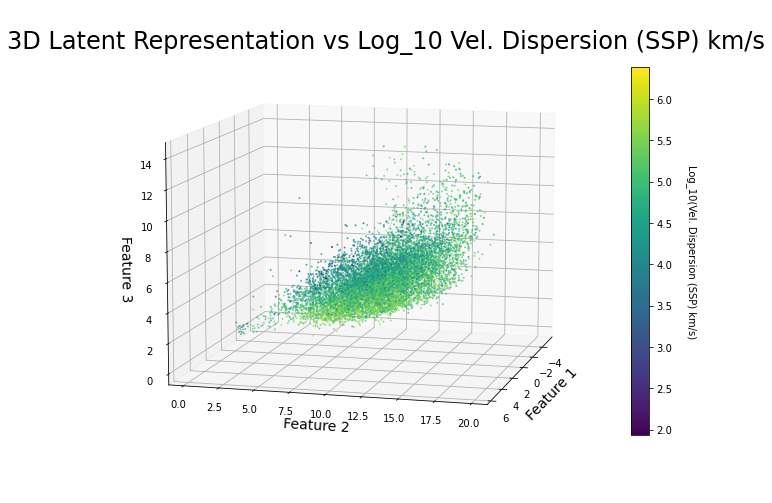

In [68]:
fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot(projection='3d')

x = final_dataset['Feat. 1']
y = final_dataset['Feat. 2']
z = final_dataset['Feat. 3']

c = final_dataset['ssp_veldisp']
p = ax.scatter(x, y, z, s=1, c=np.log(c) )
    
ax.set_xlabel('Feature 1', fontsize=14)
ax.set_ylabel('Feature 2', fontsize=14)
ax.set_zlabel('Feature 3', fontsize=14)
ax.view_init(elev=10, azim=15)

cbar = fig.colorbar(p, fraction=0.03, pad=0.04)
cbar.set_label('Log_10(Vel. Dispersion (SSP) km/s)', rotation=270, labelpad=25)
plt.title('3D Latent Representation vs Log_10 Vel. Dispersion (SSP) km/s', fontsize=24, x=0.55, y=0.98)

Text(0.55, 0.9016000000000001, '(Ellipticals Only)\n3D Latent Representation vs Log_10 Vel. Dispersion (SSP) km/s')

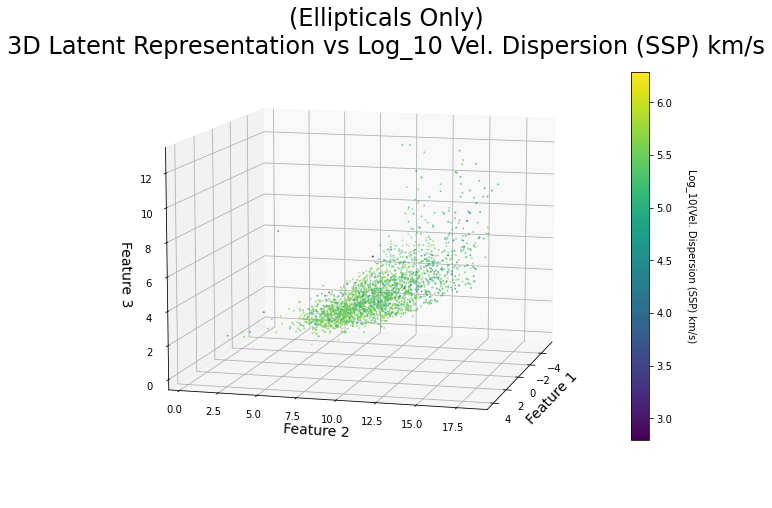

In [69]:
fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot(projection='3d')

x = final_dataset[final_dataset['elliptical']==1]['Feat. 1']
y = final_dataset[final_dataset['elliptical']==1]['Feat. 2']
z = final_dataset[final_dataset['elliptical']==1]['Feat. 3']

c = final_dataset[final_dataset['elliptical']==1]['ssp_veldisp']
p = ax.scatter(x, y, z, s=1, c=np.log(c) )
    
ax.set_xlabel('Feature 1', fontsize=14)
ax.set_ylabel('Feature 2', fontsize=14)
ax.set_zlabel('Feature 3', fontsize=14)
ax.view_init(elev=10, azim=15)

cbar = fig.colorbar(p, fraction=0.03, pad=0.04)
cbar.set_label('Log_10(Vel. Dispersion (SSP) km/s)', rotation=270, labelpad=25)
plt.title('(Ellipticals Only)\n3D Latent Representation vs Log_10 Vel. Dispersion (SSP) km/s', fontsize=24, x=0.55, y=0.98)

Text(0.55, 0.9016000000000001, '(Spirals Only)\n3D Latent Representation vs Log_10 Vel. Dispersion (SSP) km/s')

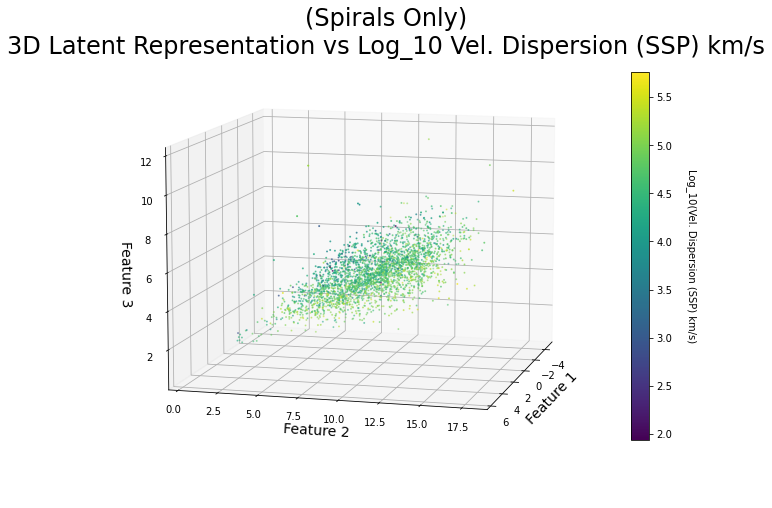

In [70]:
fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot(projection='3d')

x = final_dataset[final_dataset['spiral']==1]['Feat. 1']
y = final_dataset[final_dataset['spiral']==1]['Feat. 2']
z = final_dataset[final_dataset['spiral']==1]['Feat. 3']

c = final_dataset[final_dataset['spiral']==1]['ssp_veldisp']
p = ax.scatter(x, y, z, s=1, c=np.log(c) )
    
ax.set_xlabel('Feature 1', fontsize=14)
ax.set_ylabel('Feature 2', fontsize=14)
ax.set_zlabel('Feature 3', fontsize=14)
ax.view_init(elev=10, azim=15)

cbar = fig.colorbar(p, fraction=0.03, pad=0.04)
cbar.set_label('Log_10(Vel. Dispersion (SSP) km/s)', rotation=270, labelpad=25)
plt.title('(Spirals Only)\n3D Latent Representation vs Log_10 Vel. Dispersion (SSP) km/s', fontsize=24, x=0.55, y=0.98)

Text(0.55, 0.9016000000000001, '3D Latent Representation vs Log_10 Vel. Dispersion (exp SFH) km/s')

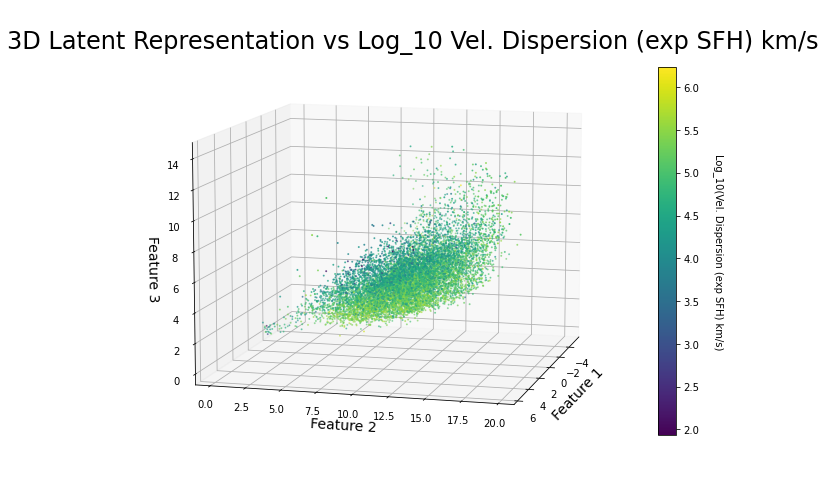

In [71]:
fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot(projection='3d')

x = final_dataset['Feat. 1']
y = final_dataset['Feat. 2']
z = final_dataset['Feat. 3']

c = final_dataset['exp_veldisp']
p = ax.scatter(x, y, z, s=1, c=np.log(c) )
    
ax.set_xlabel('Feature 1', fontsize=14)
ax.set_ylabel('Feature 2', fontsize=14)
ax.set_zlabel('Feature 3', fontsize=14)
ax.view_init(elev=10, azim=15)

cbar = fig.colorbar(p, fraction=0.03, pad=0.04)
cbar.set_label('Log_10(Vel. Dispersion (exp SFH) km/s)', rotation=270, labelpad=25)
plt.title('3D Latent Representation vs Log_10 Vel. Dispersion (exp SFH) km/s', fontsize=24, x=0.55, y=0.98)

# 3D Latent Representation vs Stellar Mass

Text(0.55, 0.9016000000000001, '3D Latent Representation vs Log Stellar Mass')

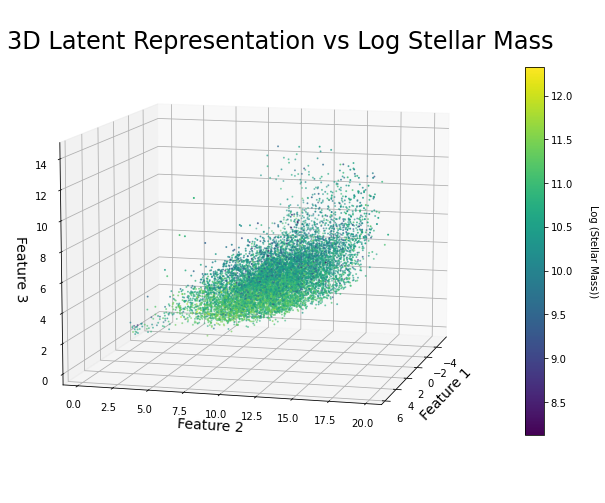

In [72]:
fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot(projection='3d')

sub = final_dataset[final_dataset['LOGMSTAR'] != -99]

x = sub['Feat. 1']
y = sub['Feat. 2']
z = sub['Feat. 3']

c = sub['LOGMSTAR']
p = ax.scatter(x, y, z, s=1, c=(c) )
    
ax.set_xlabel('Feature 1', fontsize=14)
ax.set_ylabel('Feature 2', fontsize=14)
ax.set_zlabel('Feature 3', fontsize=14)
ax.view_init(elev=10, azim=15)

cbar = fig.colorbar(p, fraction=0.03, pad=0.04)
cbar.set_label('Log (Stellar Mass))', rotation=270, labelpad=25)
plt.title('3D Latent Representation vs Log Stellar Mass', fontsize=24, x=0.55, y=0.98)

Text(0.55, 0.9016000000000001, '(Ellipticals Only)\n3D Latent Representation vs Log Stellar Mass')

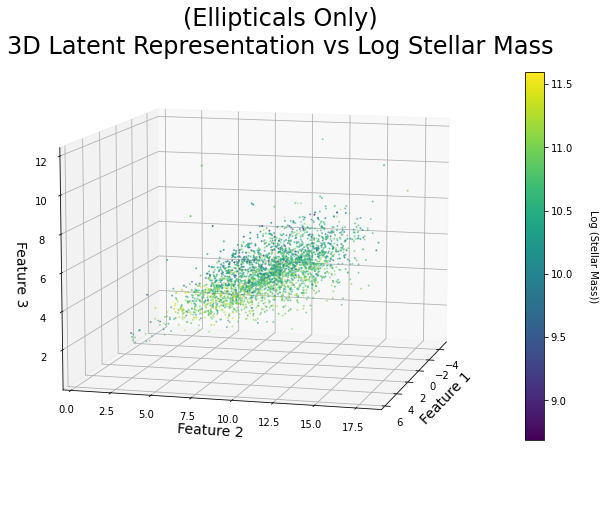

In [73]:
fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot(projection='3d')

sub = final_dataset[final_dataset['LOGMSTAR'] != -99]
sub = sub[sub['spiral'] == 1]

x = sub['Feat. 1']
y = sub['Feat. 2']
z = sub['Feat. 3']

c = sub['LOGMSTAR']
p = ax.scatter(x, y, z, s=1, c=(c) )
    
ax.set_xlabel('Feature 1', fontsize=14)
ax.set_ylabel('Feature 2', fontsize=14)
ax.set_zlabel('Feature 3', fontsize=14)
ax.view_init(elev=10, azim=15)

cbar = fig.colorbar(p, fraction=0.03, pad=0.04)
cbar.set_label('Log (Stellar Mass))', rotation=270, labelpad=25)
plt.title('(Ellipticals Only)\n3D Latent Representation vs Log Stellar Mass', fontsize=24, x=0.55, y=0.98)

Text(0.55, 0.9016000000000001, '(Spirals Only)\n3D Latent Representation vs Log Stellar Mass')

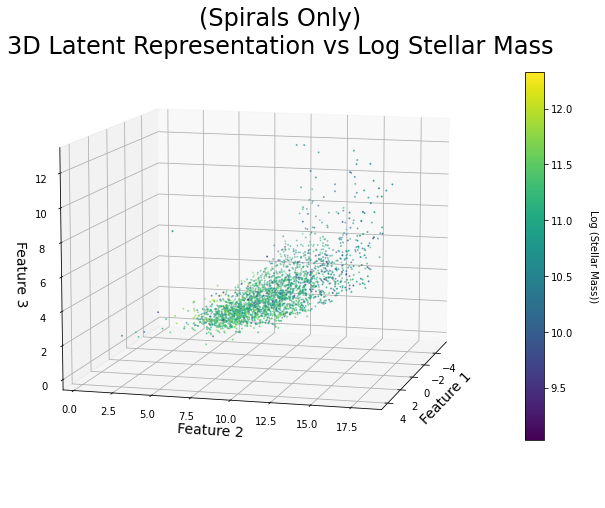

In [74]:
fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot(projection='3d')

sub = final_dataset[final_dataset['LOGMSTAR'] != -99]
sub = sub[sub['elliptical'] == 1]

x = sub['Feat. 1']
y = sub['Feat. 2']
z = sub['Feat. 3']

c = sub['LOGMSTAR']
p = ax.scatter(x, y, z, s=1, c=(c) )
    
ax.set_xlabel('Feature 1', fontsize=14)
ax.set_ylabel('Feature 2', fontsize=14)
ax.set_zlabel('Feature 3', fontsize=14)
ax.view_init(elev=10, azim=15)

cbar = fig.colorbar(p, fraction=0.03, pad=0.04)
cbar.set_label('Log (Stellar Mass))', rotation=270, labelpad=25)
plt.title('(Spirals Only)\n3D Latent Representation vs Log Stellar Mass', fontsize=24, x=0.55, y=0.98)

Text(0.5, 1, 'Latent Features Pairs vs LOGMSTAR')

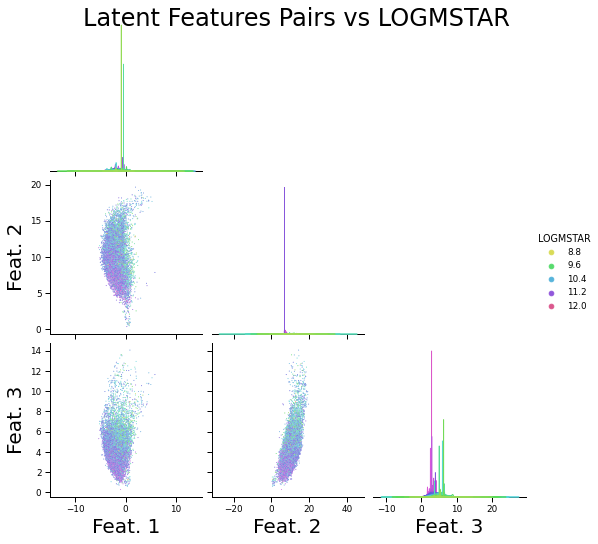

In [75]:
sub = final_dataset[final_dataset['LOGMSTAR'] != -99]
sub = sub.loc[:, ['Feat. 1', 'Feat. 2', 'Feat. 3', 'LOGMSTAR']]

sns.set_context("paper", rc={"axes.labelsize":20})
pp = sns.pairplot(data=sub, hue='LOGMSTAR', palette='hls',corner=True, plot_kws={"s": 1})
pp.fig.suptitle('Latent Features Pairs vs LOGMSTAR', fontsize=24, y=1)

# 3D Latent Representation vs Log SFR

Text(0.55, 0.9016000000000001, '3D Latent Representation vs Log SFR')

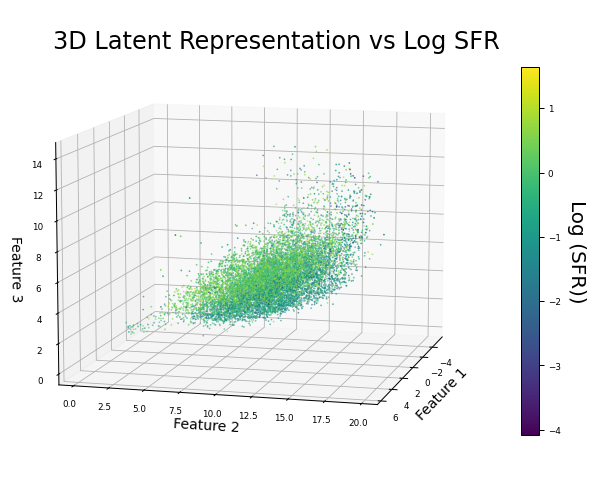

In [76]:
fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot(projection='3d')

sub = final_dataset[final_dataset['LOGSFRSED'] != -99]

x = sub['Feat. 1']
y = sub['Feat. 2']
z = sub['Feat. 3']

c = sub['LOGSFRSED']
p = ax.scatter(x, y, z, s=1, c=(c) )
    
ax.set_xlabel('Feature 1', fontsize=14)
ax.set_ylabel('Feature 2', fontsize=14)
ax.set_zlabel('Feature 3', fontsize=14)
ax.view_init(elev=10, azim=15)

cbar = fig.colorbar(p, fraction=0.03, pad=0.04)
cbar.set_label('Log (SFR))', rotation=270, labelpad=25)
plt.title('3D Latent Representation vs Log SFR', fontsize=24, x=0.55, y=0.98)

Text(0.55, 0.9016000000000001, '(Ellipticals Only)\n3D Latent Representation vs Log SFR')

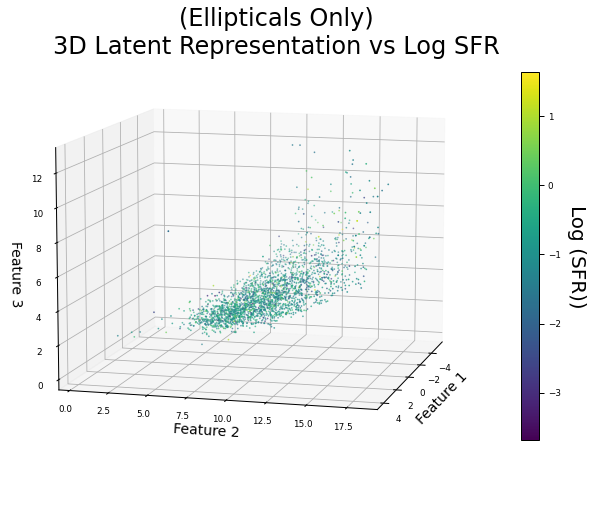

In [77]:
fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot(projection='3d')

sub = final_dataset[final_dataset['LOGSFRSED'] != -99]
sub = sub[sub['elliptical'] == 1]

x = sub['Feat. 1']
y = sub['Feat. 2']
z = sub['Feat. 3']

c = sub['LOGSFRSED']
p = ax.scatter(x, y, z, s=1, c=(c) )
    
ax.set_xlabel('Feature 1', fontsize=14)
ax.set_ylabel('Feature 2', fontsize=14)
ax.set_zlabel('Feature 3', fontsize=14)
ax.view_init(elev=10, azim=15)

cbar = fig.colorbar(p, fraction=0.03, pad=0.04)
cbar.set_label('Log (SFR))', rotation=270, labelpad=25)
plt.title('(Ellipticals Only)\n3D Latent Representation vs Log SFR', fontsize=24, x=0.55, y=0.98)

Text(0.55, 0.9016000000000001, '(Spirals Only)\n3D Latent Representation vs Log SFR')

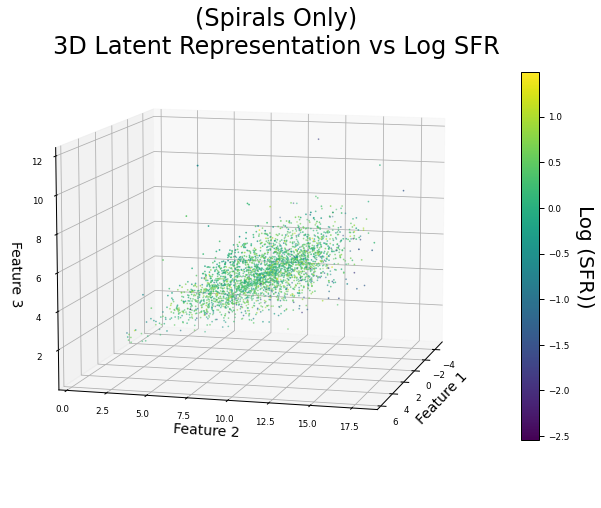

In [78]:
fig = plt.figure(figsize=(11, 9))
ax = fig.add_subplot(projection='3d')

sub = final_dataset[final_dataset['LOGSFRSED'] != -99]
sub = sub[sub['spiral'] == 1]

x = sub['Feat. 1']
y = sub['Feat. 2']
z = sub['Feat. 3']

c = sub['LOGSFRSED']
p = ax.scatter(x, y, z, s=1, c=(c) )
    
ax.set_xlabel('Feature 1', fontsize=14)
ax.set_ylabel('Feature 2', fontsize=14)
ax.set_zlabel('Feature 3', fontsize=14)
ax.view_init(elev=10, azim=15)

cbar = fig.colorbar(p, fraction=0.03, pad=0.04)
cbar.set_label('Log (SFR))', rotation=270, labelpad=25)
plt.title('(Spirals Only)\n3D Latent Representation vs Log SFR', fontsize=24, x=0.55, y=0.98)

Text(0.5, 1, 'Latent Features Pairs vs LOGSFRSED')

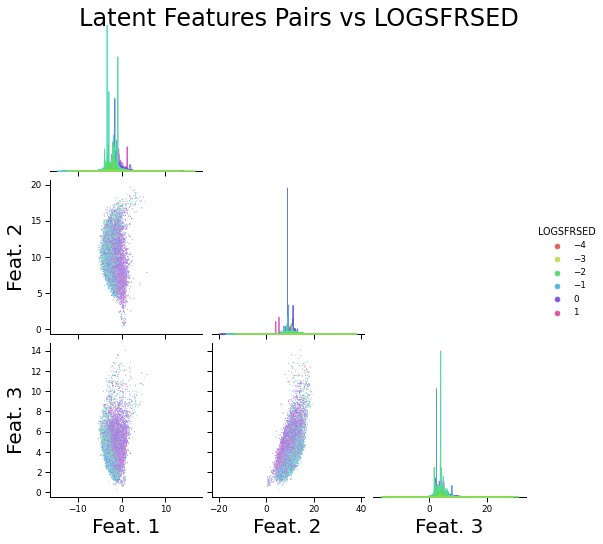

In [79]:
sub = final_dataset[final_dataset['LOGMSTAR'] != -99]
sub = sub.loc[:, ['Feat. 1', 'Feat. 2', 'Feat. 3', 'LOGSFRSED']]

sns.set_context("paper", rc={"axes.labelsize":20})
pp = sns.pairplot(data=sub, hue='LOGSFRSED', palette='hls',corner=True, plot_kws={"s": 1})
pp.fig.suptitle('Latent Features Pairs vs LOGSFRSED', fontsize=24, y=1)

In [29]:
sub = final_dataset[final_dataset['LOGMSTAR'] != -99]
sub = sub.loc[:, ['Feat. 1', 'Feat. 2', 'Feat. 3', 'LOGMSTAR', 'LOGSFRSED']]
sub['LOGSSFR'] = np.log(np.exp(sub['LOGSFRSED'])/np.exp(sub['LOGMSTAR']))
sub = sub.loc[:, ['Feat. 1', 'Feat. 2', 'Feat. 3', 'LOGSSFR']]

sns.set_context("paper", rc={"axes.labelsize":20})
pp = sns.pairplot(data=sub, hue='LOGSSFR', palette='hls', corner=True, plot_kws={"s": 1}, diag_kind=None)
pp.fig.suptitle('Latent Features Pairs vs LOGSSFR', fontsize=24, y=1.05)


NameError: name 'final_dataset' is not defined